# Fun with language modelling

Если вы пропустили лекцию, то посмотрите слайды к ней — они где-то есть. Также полезно почитать:

* [Unreasonable effectiveness of RNN](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) (Andrej Karpathy)
* [Официальный пример от PyTorch](https://github.com/pytorch/examples/tree/master/word_language_model)

Рекомендуется заранее всё прочитать, чтобы понять, что от вас хотят. При желании, можете переписать всё так, как подсказывает ваше сердце.

---

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

text_path = '/content/drive/MyDrive/Language Models/fathers_and_sons.txt'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader

import numpy as np

import matplotlib.pyplot as plt
import re
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download('punkt')
%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# посмотрим, все ли ок с текстом
with open(text_path) as file:
  text = file.read()
  print(text[81761: 81811])

Мы действуем в силу того, что мы признаем полезным


## Препроцессинг (3 балла)

Возьмите какие-нибудь сырые данные. Википедия, «Гарри Поттер», «Игра Престолов», тексты Монеточки, твиты Тинькова — что угодно.

Для простоты будем делать char-level модель. Выкиньте из текстов все ненужные символы (можете оставить только алфавит и, пунктуацию). Сопоставьте всем различным символам свой номер. Удобно это хранить просто в питоновском словаре (`char2idx`). Для генерации вам потребуется ещё и обратный словарь (`idx2char`). Вы что-то такое должны были писать на вступительной — можете просто переиспользовать код оттуда.

Заранее зарезервируйте айдишники под служебные символы: `<START>`, `<END>`, `<PAD>`, `<UNK>`.

Клёво будет написать отдельный класс, который делает токенизацию и детокенизацию.

In [ ]:
class Vocab:
    def __init__(self, text):
        self.text = text
        self.char_regex = re.compile(r'[а-яА-Я.,:;-?!]')
        self.char2idx = {'<START>': 1, '<END>': 2, '<PAD>': 0, '<UNK>': 3}

        for char in self.extract_chars(self.text):
          self.char2idx[char] = len(self.char2idx) if char not in self.char2idx else self.char2idx[char]
        self.idx2char = {idx: char for (char, idx) in self.char2idx.items()}
    
    def tokenize(self, sequence):
        sequence = self.extract_chars(sequence)
        return [self.char2idx[char] for char in sequence]
    
    def extract_chars(self, text):
      return self.char_regex.findall(text)
    
    def detokenize(self, sequence):
        return ''.join([self.idx2char[idx] for idx in sequence])
    
    def __len__(self):
        return len(self.char2idx)

In [ ]:
class TextDataset(Dataset):
    
    def __init__(self, data_path, max_length=128):
        self.max_length = max_length
        # загрузите данные
        with open(data_path) as file:
          data = file.read()

        # обучите вокаб
        self.vocab = Vocab(data)

        # разделите данные на отдельные сэмплы для обучения
        # (просто список из сырых строк)
        self.data = sent_tokenize(data)
    
    def __len__(self):
        return len(self.data)
    
    def add_pad(self, sequence):
      if len(sequence) < self.max_length:
        sequence.extend([self.vocab.char2idx['<PAD>'] for _ in range(self.max_length - len(sequence))])
      else:
        sequence = sequence[: self.max_length]
      return sequence
    
    def __getitem__(self, idx):
        text_chunk = self.data[idx]
        sample = self.add_pad(self.vocab.tokenize(text_chunk[:-1]))
        target = self.add_pad(self.vocab.tokenize(text_chunk[1: ]))
        target = torch.tensor(target, dtype=torch.long)
        sample = torch.tensor(sample, dtype=torch.long)
        return sample, target

Если у вас какой-то большой массив текста (скажем, статьи Википедии), вы можете просто нарезать из него кусочки фиксированной длины и так их подавать в модель.

Если же вы хотите приключений, то можно разбить этот текст на предложения (`nltk.sent_tokenize`), и тогда все примеры будут разной длины. По соображениям производительности, вы не хотите использовать самые длинные и самые короткие сэмплы, поэтому имеет смысл обрезать их по длине.

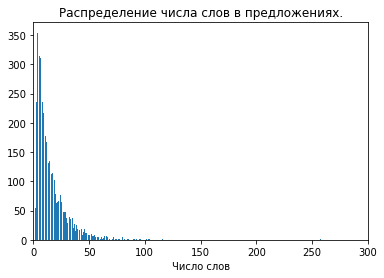

In [ ]:
plt.hist([len(word_tokenize(x)) for x in sent_tokenize(text)], bins=350)
plt.title('Распределение числа слов в предложениях.')
plt.xlabel('Число слов')
plt.xlim((0, 300))
plt.show()

Разобьём на обучение и валидацию:

In [ ]:
dataset = TextDataset(text_path, 256)

train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size])

## Модель (3 балла)

Примерно такое должно зайти:

* Эмбеддинг
* LSTM / GRU
* Линейный слой
* Softmax

In [ ]:
class LM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout, tie_weights):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.output_dim = vocab_size
        self.num_layers = num_layers
        self.encoder = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.GRU(embedding_dim, hidden_dim, num_layers, dropout=dropout, batch_first=True)
        self.decoder = nn.Linear(hidden_dim, vocab_size)
        self.drop = nn.Dropout(dropout)
        
        if tie_weights:
            # "Using the Output Embedding to Improve Language Models" (Press & Wolf 2016)
            # https://arxiv.org/abs/1608.05859
            assert hidden_dim == embedding_dim
            self.decoder.weight = self.encoder.weight

    def forward(self, input, hidden):
        emb = self.drop(self.encoder(input))
        output, hidden = self.rnn(emb, hidden)
        output = self.drop(output)
        decoded = self.decoder(output.reshape(output.size(0)*output.size(1), output.size(2)))
        return decoded.view(output.size(0), output.size(1), decoded.size(1)), hidden

    def init_hidden(self, batch_size):
        # начальный хидден должен быть нулевой
        # (либо хоть какой-то константный для всего обучения)
        return torch.zeros(self.num_layers, batch_size, self.hidden_dim)

## Обучение

In [ ]:
epochs = 10
lr = 1e-3 
batch_size = 64

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = LM(
    vocab_size = len(dataset.vocab),
    embedding_dim = 256,
    hidden_dim = 256,
    num_layers = 4,
    dropout = 0.1,
    tie_weights= True
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

train = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test = DataLoader(test_set, batch_size=batch_size)

In [ ]:
train_loss_history = []
test_loss_history = []
for epoch in range(1, epochs + 1):
  # обучение
    train_loss = 0
    test_loss = 0
    model.train()
    for x, y in train:
        
        optimizer.zero_grad()
        x = x.to(device)
        y = y.to(device)
        hidden = model.init_hidden(len(x)).to(device)
        output, hidden = model(x, hidden)
        loss = criterion(output.reshape(-1, len(dataset.vocab)), y.reshape(output.shape[0] * output.shape[1]))
        train_loss += loss.item()
        train_loss_history.append(loss.item())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.2)
        optimizer.step()

    train_loss /= len(train)
  # тестирование
    for x, y in test:
      with torch.no_grad():
        x = x.to(device)
        y = y.to(device)

        hidden = model.init_hidden(len(x)).to(device)
        output, hidden = model(x, hidden)
        loss = criterion(output.reshape(-1, len(dataset.vocab)), y.reshape(output.shape[0] * output.shape[1]))
        test_loss += loss.item()
        test_loss_history.append(loss.item())
    test_loss /= len(test)
    print(f'Epoch {epoch}')
    print(f'\tTrain | Loss: {train_loss:.4f}') 
    print(f'\tTest  | Loss: {test_loss:.4f}')
        # сдесь нужно сделать то же самое, только без backward

Epoch 1
	Train | Loss: 0.8253
	Test  | Loss: 0.6710
Epoch 2
	Train | Loss: 0.5858
	Test  | Loss: 0.6279
Epoch 3
	Train | Loss: 0.5555
	Test  | Loss: 0.6022
Epoch 4
	Train | Loss: 0.5330
	Test  | Loss: 0.5877
Epoch 5
	Train | Loss: 0.5166
	Test  | Loss: 0.5725
Epoch 6
	Train | Loss: 0.5082
	Test  | Loss: 0.5752
Epoch 7
	Train | Loss: 0.4813
	Test  | Loss: 0.5382
Epoch 8
	Train | Loss: 0.4624
	Test  | Loss: 0.5241
Epoch 9
	Train | Loss: 0.4450
	Test  | Loss: 0.5218
Epoch 10
	Train | Loss: 0.4379
	Test  | Loss: 0.5176


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Language Models/model.pth')

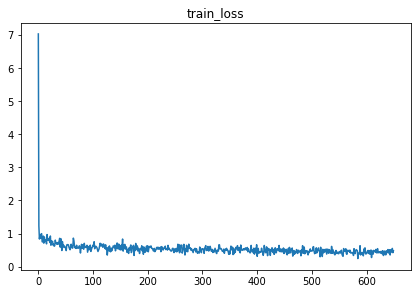

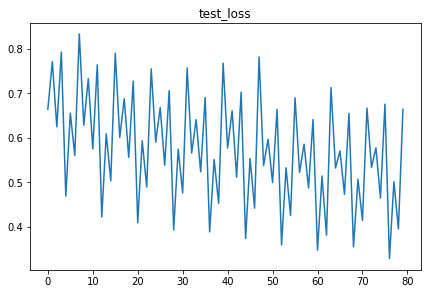

In [ ]:
# график лосса на трейне
plt.figure(figsize=(7, 10))
plt.subplot(211)
plt.plot(train_loss_history)
plt.title('train_loss')
plt.show()

# график лосса на тесте
plt.figure(figsize=(7, 10))
plt.subplot(212)
plt.plot(test_loss_history)
plt.title('test_loss')
plt.show()

## Спеллчекер (3 балла)

Из языковой модели можно сделать простенький спеллчекер: можно визуализировать лоссы на каждом символе (либо какой-нибудь другой показатель неуверенности).

Бонус: можете усреднить перплексии по словам и выделять их, а не отдельные символы.

In [ ]:
from IPython.core.display import display, HTML

def print_colored(sequence, intensities, delimeter=''):
    html = delimeter.join([
        f'<span style="background: rgb({255}, {255-x}, {255-x})">{c}</span>'
        for c, x in zip(sequence, intensities) 
    ])
    display(HTML(html))

print_colored('Налейте мне экспрессо'.split(), [0, 0, 100], ' ')

sequence = 'Эту домашку нужно сдать втечении двух недель'
intensities = [0]*len(sequence)
intensities[25] = 50
intensities[26] = 60
intensities[27] = 70
intensities[31] = 150
print_colored(sequence, intensities)

In [ ]:
def spellcheck(sequence):
    model.eval()
    losses = []
    # векторизуйте sequence; паддинги делать не нужно
    encoded_seq = torch.LongTensor(dataset.add_pad(dataset.vocab.tokenize(sequence[:-1]))).reshape(1, -1).to(device)
    target = torch.LongTensor(dataset.add_pad(dataset.vocab.tokenize(sequence[1: ]))).reshape(1, -1).to(device)
    # прогоните модель и посчитайте лосс, но не усредняйте
    # с losses можно что-нибудь сделать для визуализации; например, в какую-нибудь степень возвести
    hidden = model.init_hidden(1).to(device)
    output, _ = model(encoded_seq, hidden)
    for i in range(output.shape[1]):
      loss = criterion(output[:, i, :].reshape(-1, len(dataset.vocab)), target[:, i].reshape(1))
      losses.append(loss.item() * 15)
    
    print_colored(sequence, losses)

In [ ]:
sequences = ['В этом претложениии очен много очепяток.', 
             'Здесь появилась лишнняя буква.', 
             'В этом предложении все нормально.', 
             'Чтонибудь пишеться чериз дефис.', 
             'Слова нрпдзх не сущесдвует.']

for sequence in sequences:
    spellcheck(sequence)

## Генерация предложений (3 балла)

* Поддерживайте hidden state при генерации. Не пересчитывайте ничего больше одного раза.
* Прикрутите температуру: это когда при сэмплировании все логиты (то, что перед софтмаксом) делятся на какое-то число (по умолчанию 1, тогда ничего не меняется). Температура позволяет делать trade-off между разнообразием и правдоподобием (подробнее — см. блог Карпатого).
* Ваша реализация должна уметь принимать строку seed — то, с чего должно начинаться сгенерированная строка.

In [ ]:
def sample(num_tokens, seed="", temperature=1.0):
    model.eval()
        
    hidden = model.init_hidden(1).to(device)
    input = torch.LongTensor(dataset.vocab.tokenize(seed)).reshape(1, -1).to(device)     
    
    continuation = ''
    
    for _ in range(num_tokens):
        output, hidden = model(input, hidden)
        
        token_probas = output.squeeze().div(temperature).exp().cpu()
        token = torch.multinomial(token_probas, 1)[0]
        
        continuation += dataset.vocab.idx2char[token.item()]
        input = torch.LongTensor(dataset.vocab.tokenize(seed + continuation)).reshape(1, -1).to(device)
    
    return continuation

In [ ]:
beginnings = ['Шел медведь по лесу', 
              'Встретились англичанин, американец и русский. Англичанин говорит:',
              'Так вот, однажды качки решили делать ремонт',
              'Поручик Ржевский был',
              'Идёт Будда с учениками по дороге',
              'Мюллер: Штирлиц, где вы были в 1938 году?',
              'Засылают к нам американцы шпиона под видом студента',
              'Подъезжает электричка к Долгопе:']

for beginning in beginnings:
    print(f'{beginning}... {sample(10, beginning)}')
    print()

Шел медведь по лесу... роврещвлрЧ

Встретились англичанин, американец и русский. Англичанин говорит:... сВааиоазар

Так вот, однажды качки решили делать ремонт... аеииееоогТ

Поручик Ржевский был... оТррцаереа

Идёт Будда с учениками по дороге... внрчОвствз

Мюллер: Штирлиц, где вы были в 1938 году?... аМиМсаМ.Мс

Засылают к нам американцы шпиона под видом студента... аМанакдано

Подъезжает электричка к Долгопе:... еПППеППППП

